In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, Markdown

import sys
sys.path.insert(0, '../py_scripts')

import numpy as np
import scipy as sp
import pandas as pd
import numpy.random as rand
import matplotlib.pyplot as plt
import seaborn as sns


import time
import pickle


import noise_models as noise
import model_fitting as fit
import fig_plot as fplot
import thermo_models as thermo



sns.set(context='talk', font_scale=1.0, color_codes=True, palette='deep', style='ticks', 
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':100, 'text.usetex':False})

# Instructions

This notebook runs the fitting routines for the thermodynamic push and push-pull models. To make this run, you will need to setup the input files as follows:

1. Make datasets.csv file.
This file lists the different datasets, models, and fit parameters. The columns of this file should be:
dataset: The name of each file containing a different construct.

    model: The type of model you wish to use to fit each model. This determines which fit parameters will be necessary to fit each data set. The options are: 
    
        substrate_only: This model assumes that only the substrate exists and will only fit the background pplation rate.
    
        non-pplatable: This moel assumes the substrate cannot be pplated, and so has no fit parameters. However, we can still predict the distribution of observed pplated substrate based on the empty cell noise controls, so it is still useful to include these datasets.
    
        push: Model assumes the existence of substrate and kinase and will fit the background pplation rate, kinase zipper binding affinity, and kinase pplation rate.
    
        pushpull: Model fits the full pushpull construct with background pplation rate, kinase zipper binding affinity, kinase pplation rate, pptase zipper binding affinity, and pptase depplation rate.

    kinase_variant: Name of the kinase variant pplation rate parameter.

    kinase_zipper: Name of the kinase zipper binding affinity parameter.

    pptase_variant: Name of the pptase variant  depplation rate parameter. 

    pptase_zipper: Name of the pptase zipper binding affinity parameter. 

    substrate_col: Name of the column containing the substrate in the data file.

    phospho_col: Name of the column containing the pplated substrate in the data file.

    writer_col: Name of the column containing the kinase in the data file.

    eraser_col:  Name of the column containing the pptase in the data file.

    Note: All parameters are shared across and within datasets/models if they have the same name. This is true even if they correspond to different thermodynamic parameters (e.g., if the pptase and kinase zipper have the same name, then they are the same parameter). To ensure unique parameters, make sure they have unique names. The background pplation rate is also shared by all models by default.

2. Make noise_key.csv file
This file specifies the noise control datasets. The columns should be:

    component: The molecule species (e.g., writer, eraser, substrate, phospho).

    anti_label: The label of the column containig the antibody values for the active cells.

    GFP_label: The label of the column containig the GFP values for the active cells.

    empty_anti_label: The label of the column containig the antibody values for the empty cells.

    empty_GFP_label: The label of the column containig the GFP values for the empty cells.

3. Rename noise dataset files as follows:

    noise_writer.csv

    noise_eraser.csv

    noise_substrate_phospho_combined.csv

    noise_empty_cell.csv

In [12]:
seed = 42

print("Seed:", seed)

rand.seed(seed)


# name of dataset folder
label = "21_10_15_highgating"
# label = "21_10_15_medhighgating"


df_data_info = pd.read_csv("../data/"+label+"/datasets.csv", sep=', ', engine='python')

display(df_data_info)

noise_key = pd.read_csv("../data/"+label+"/noise_key.csv", sep=', ', engine='python')
noise_key.set_index("component", inplace=True)
display(noise_key)

# load datasets

df_list = []
for index, row in df_data_info.iterrows():
    
    
    df = pd.read_csv("../data/{}/{}.csv".format(label, row['dataset']))     
    df = df.drop("Unnamed: 0", axis=1, errors='ignore').sample(frac=1.0, replace=True, random_state=seed).reset_index(drop=True)
#     display(df)
    
    if row['model'] == 'push' or row['model'] == "substrate_only" or row['model'] == "non-pplatable":
        df = df[[row['substrate_col'],row['phospho_col'],row['writer_col']]].rename(columns={row['substrate_col']:'ST_anti_exp', 
                                                                                     row['phospho_col']:'SpT_anti_exp', 
                                                                                     row['writer_col']:'WT_anti_exp'})
    elif row['model'] == 'pushpull':
        df = df[[row['substrate_col'],row['phospho_col'],row['writer_col'],row['eraser_col']]].rename(columns={row['substrate_col']:'ST_anti_exp', 
                                                                                                       row['phospho_col']:'SpT_anti_exp', 
                                                                                                       row['writer_col']:'WT_anti_exp',
                                                                                                       row['eraser_col']:'ET_anti_exp'})

    
    df['dataset'] = row['dataset']      
    df_list.append(df)
    
# dataframe containing all datasets   
df_data = pd.concat(df_list) #.drop("Unnamed: 0", axis=1, errors='ignore')
df_data.set_index("dataset", inplace=True, append=True)
df_data = df_data.reorder_levels(df_data.index.names[::-1])
df_data.fillna(0.0, inplace=True)



print(len(df_data.index))
df_data = df_data[(df_data[df_data.columns] >= 0).all(axis=1)]
print(len(df_data.index))

# record fraction of phospho substrate
df_data['Sp_frac_anti_exp'] = df_data['SpT_anti_exp'] / df_data['ST_anti_exp']


display(df_data)

Seed: 42


,dataset,model,kinase_variant,kinase_zipper,pptase_variant,pptase_zipper,substrate_col,phospho_col,writer_col,eraser_col
0,127,substrate_only,NaN,NaN,NaN,NaN,ST,SpT,WT,NaN
1,174,non-pplatable,174,L+A,NaN,NaN,ST,SpT,WT,NaN
2,375,push,375,L+A,NaN,NaN,ST,SpT,WT,NaN
3,419,push,419,L+A,NaN,NaN,ST,SpT,WT,NaN
4,421,push,kinase_dead,L+A,NaN,NaN,ST,SpT,WT,NaN
5,E+A,push,kinase_wt,E+A,NaN,NaN,ST,SpT,WT,NaN
6,E+E,push,kinase_wt,E+E,NaN,NaN,ST,SpT,WT,NaN
7,L+A,push,kinase_wt,L+A,NaN,NaN,ST,SpT,WT,NaN
8,RR+A,push,kinase_wt,kinase_non-binding,NaN,NaN,ST,SpT,WT,NaN
9,with pptase,pushpull,kinase_wt,L+A,pptase_wt,L+A,ST,SpT,WT,pptase


,anti_label,GFP_label,empty_anti_label,empty_GFP_label
component,,,,
writer,WT,GFP,WT,GFP
eraser,pptase,GFP,pptase,GFP
substrate,ST,GFP,ST,GFP
phospho,SpT,GFP,SpT,GFP


132262
132262


ST_anti_exp  SpT_anti_exp  WT_anti_exp  ET_anti_exp  \
dataset                                                                  
127         0       596.003052    127.600983   139.194336     0.000000   
            1       642.792908     47.050320    63.249672     0.000000   
            2       504.310577     60.162514    80.487480     0.000000   
            3       975.909546    207.053024   150.405548     0.000000   
            4       504.870697     50.226593   122.371445     0.000000   
...                        ...           ...          ...          ...   
pptase dead 20012   728.979065   1658.475220  1414.776611  3427.544922   
            20013   861.156677   3132.601562  1403.224487  4458.793457   
            20014   857.985962    102.973625  1212.635132  1800.807251   
            20015   473.853760   1973.187866  1084.941284  1246.285767   
            20016  2178.468994   6118.945312  2886.015625  8448.372070   

                   Sp_frac_anti_exp  
dataset                              
127         0              0.214095  
            1              0.073197  
            2              0.119297  
            3              0.212164  
            4              0.099484  
...                             ...  
pptase dead 20012          2.275066  
            20013          3.637667  
            20014          0.120018  
            20015          4.164128  
            20016          2.808828  

[132262 rows x 5 columns]

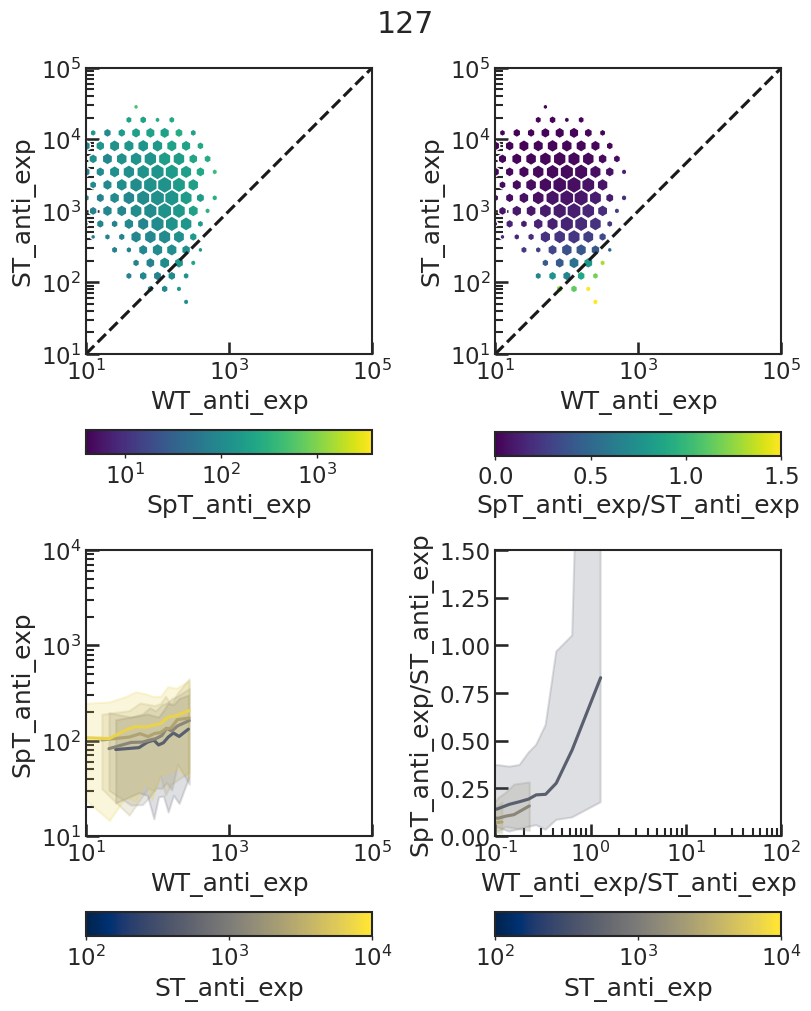

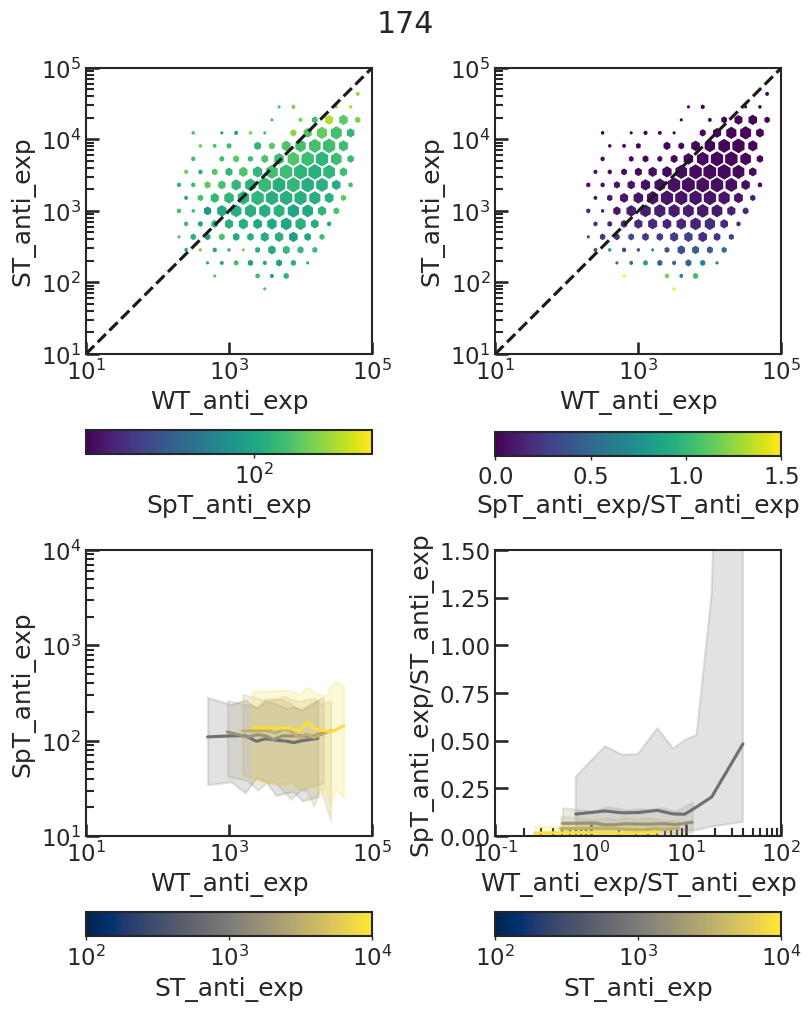

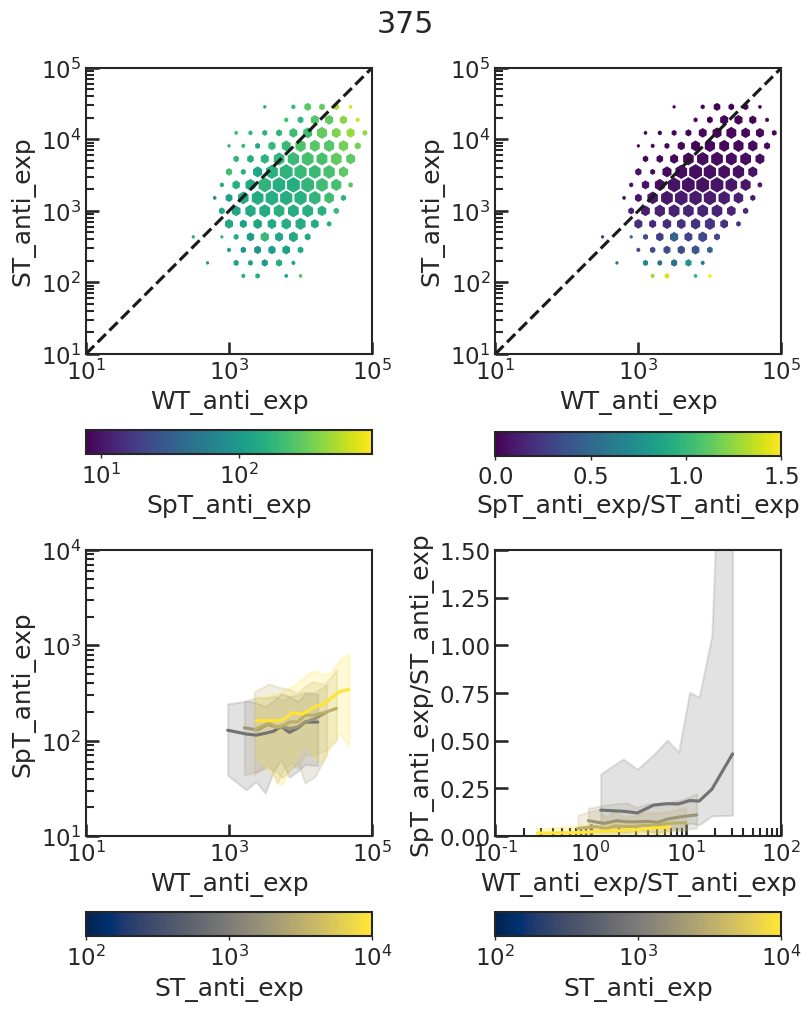

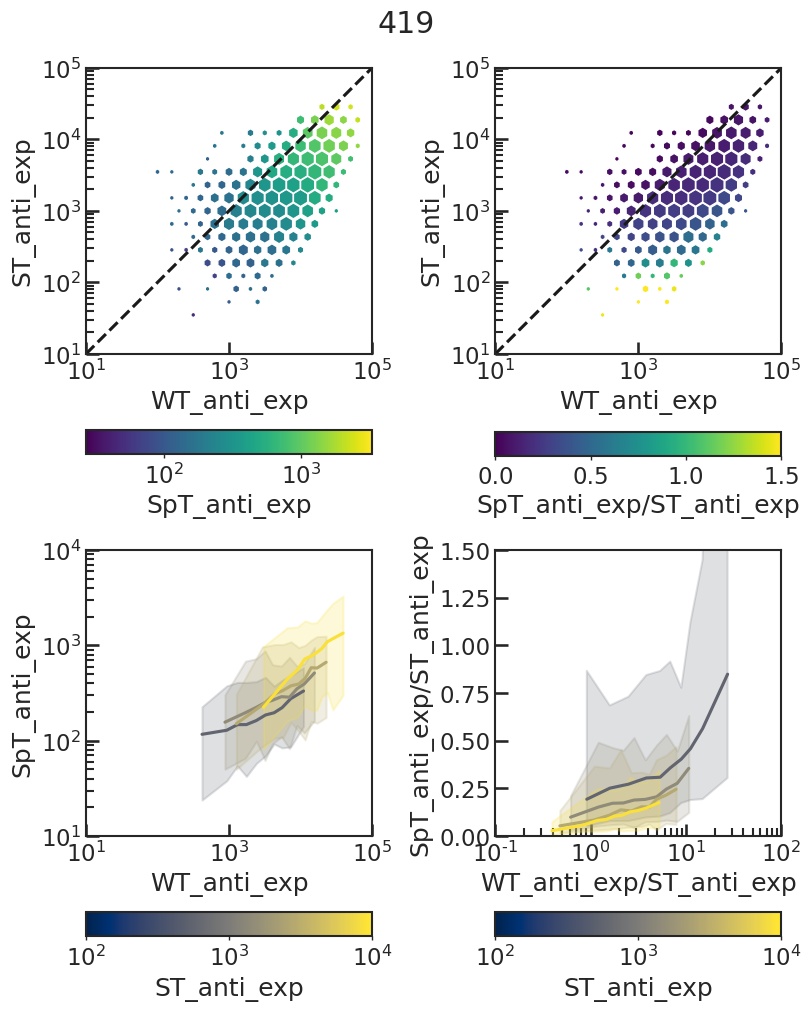

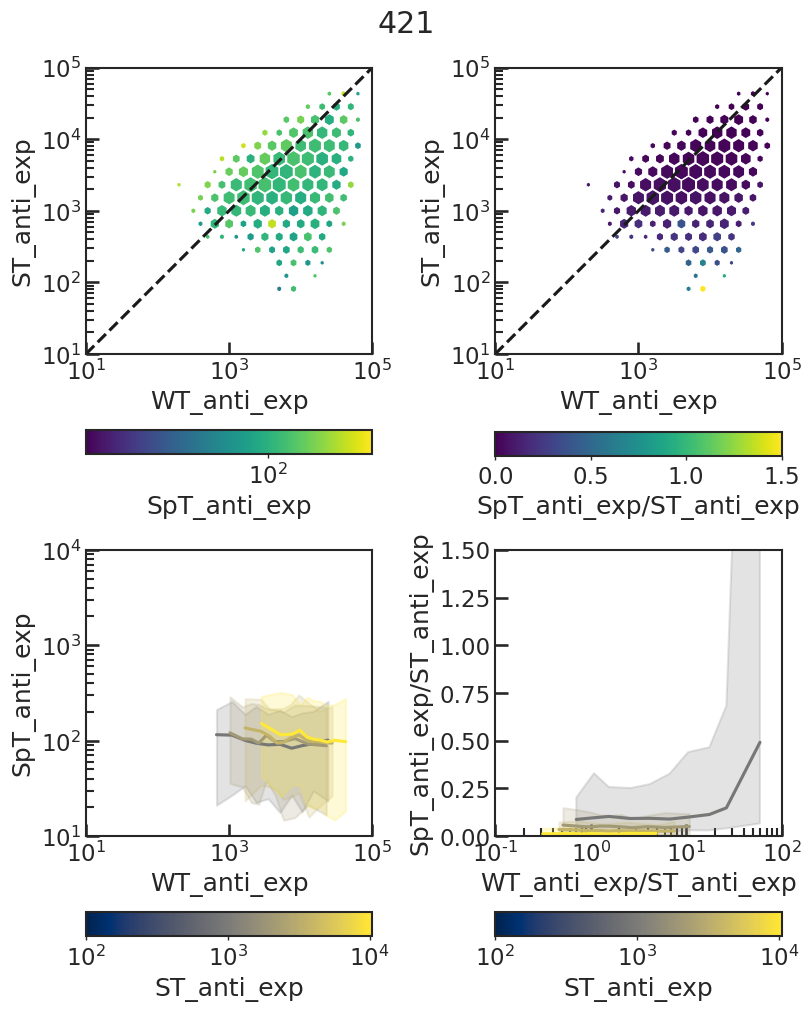

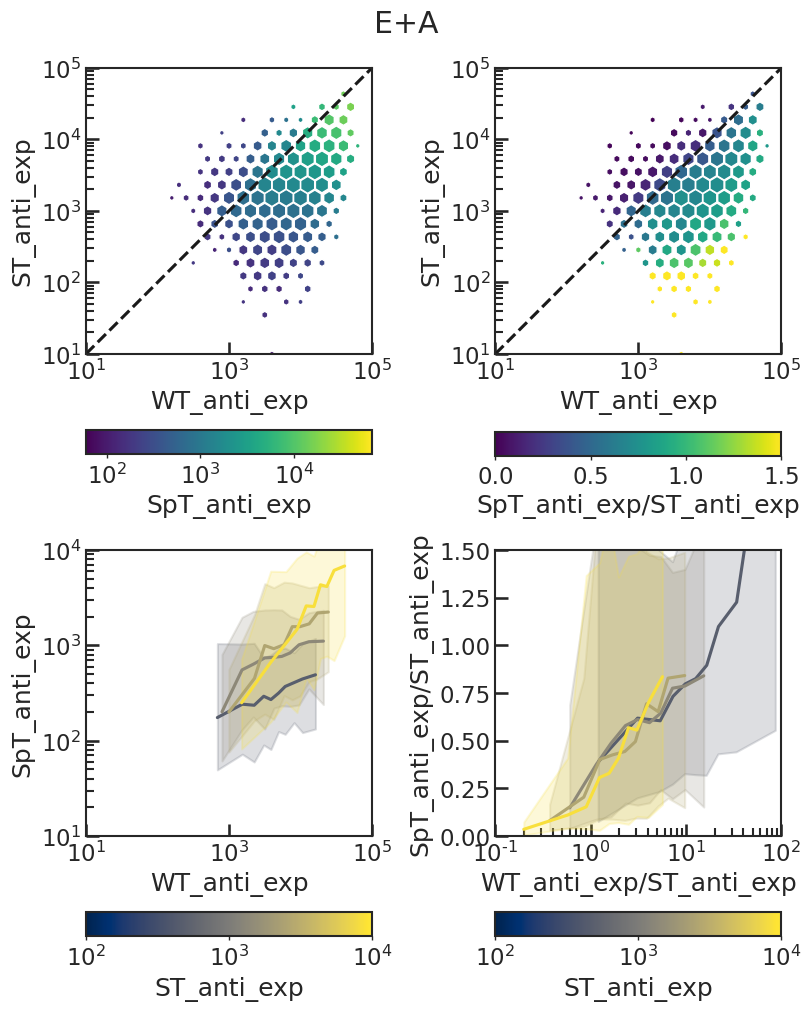

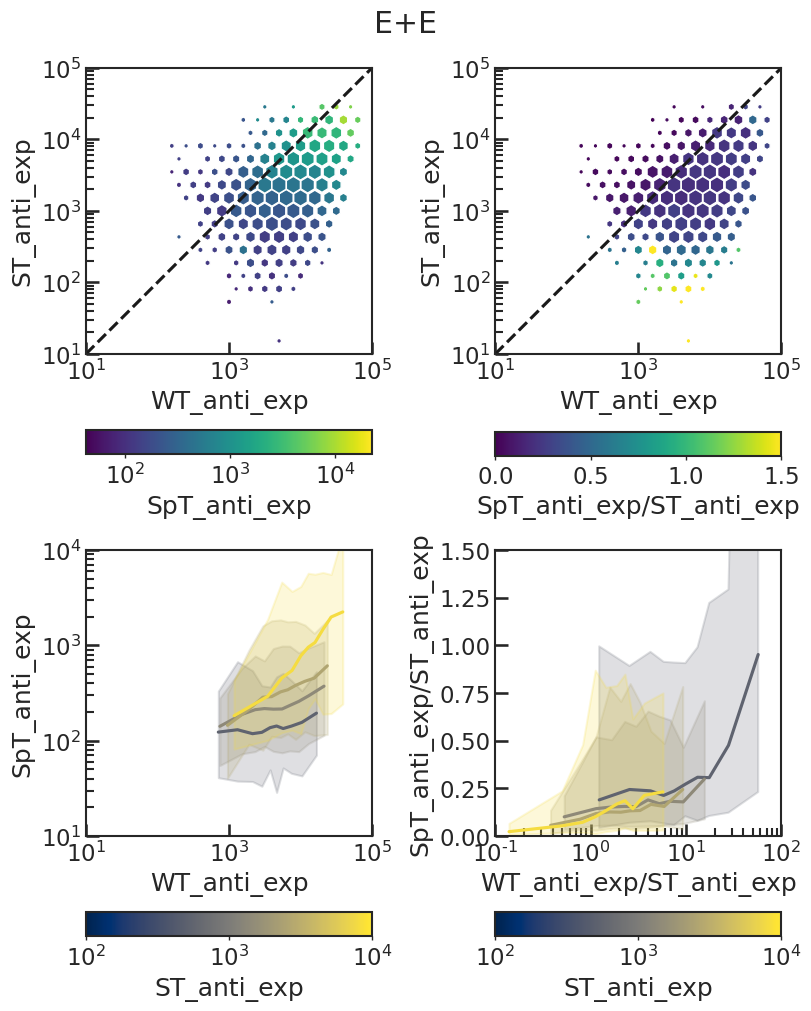

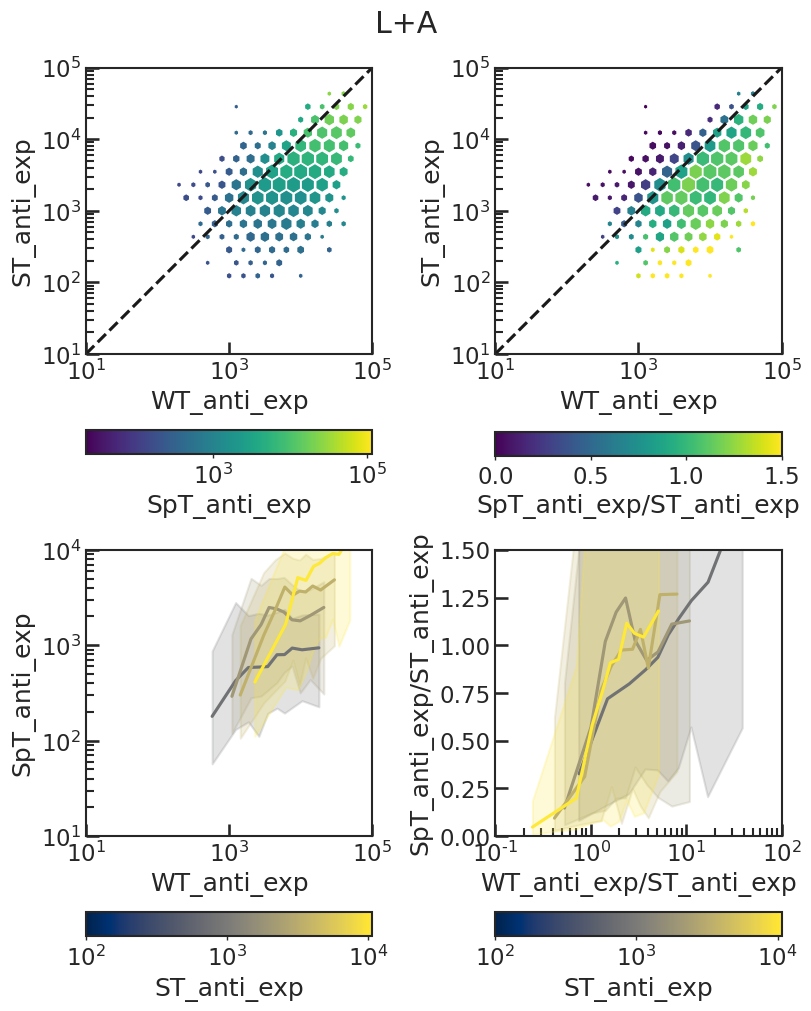

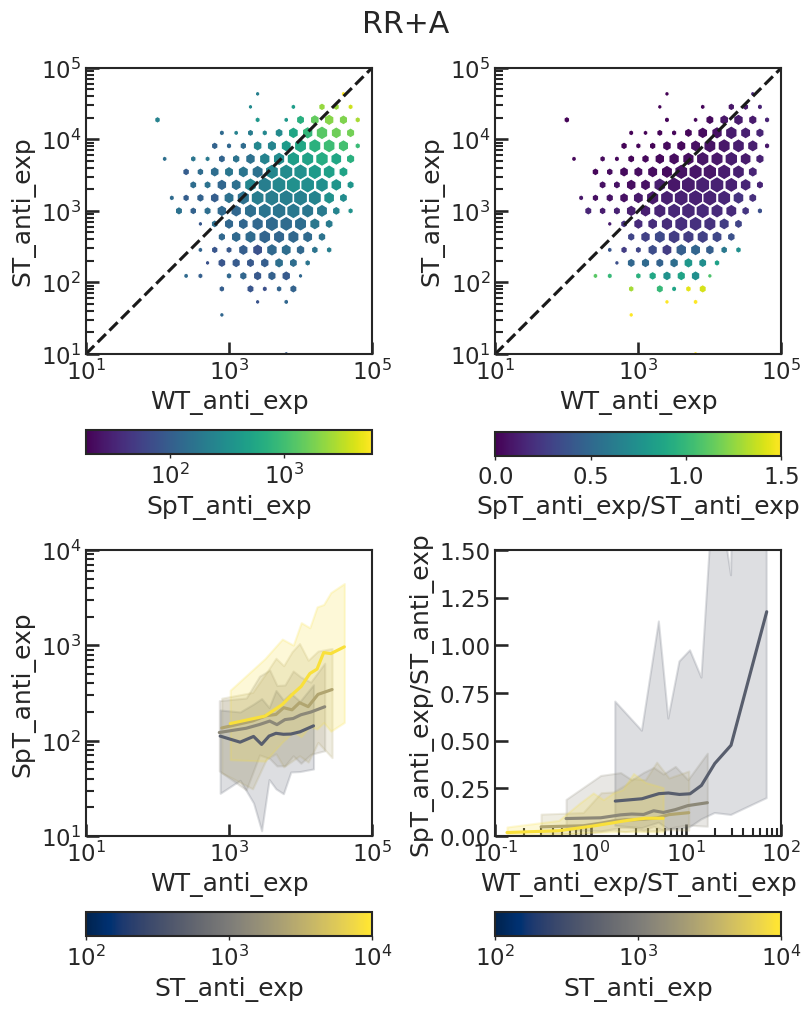

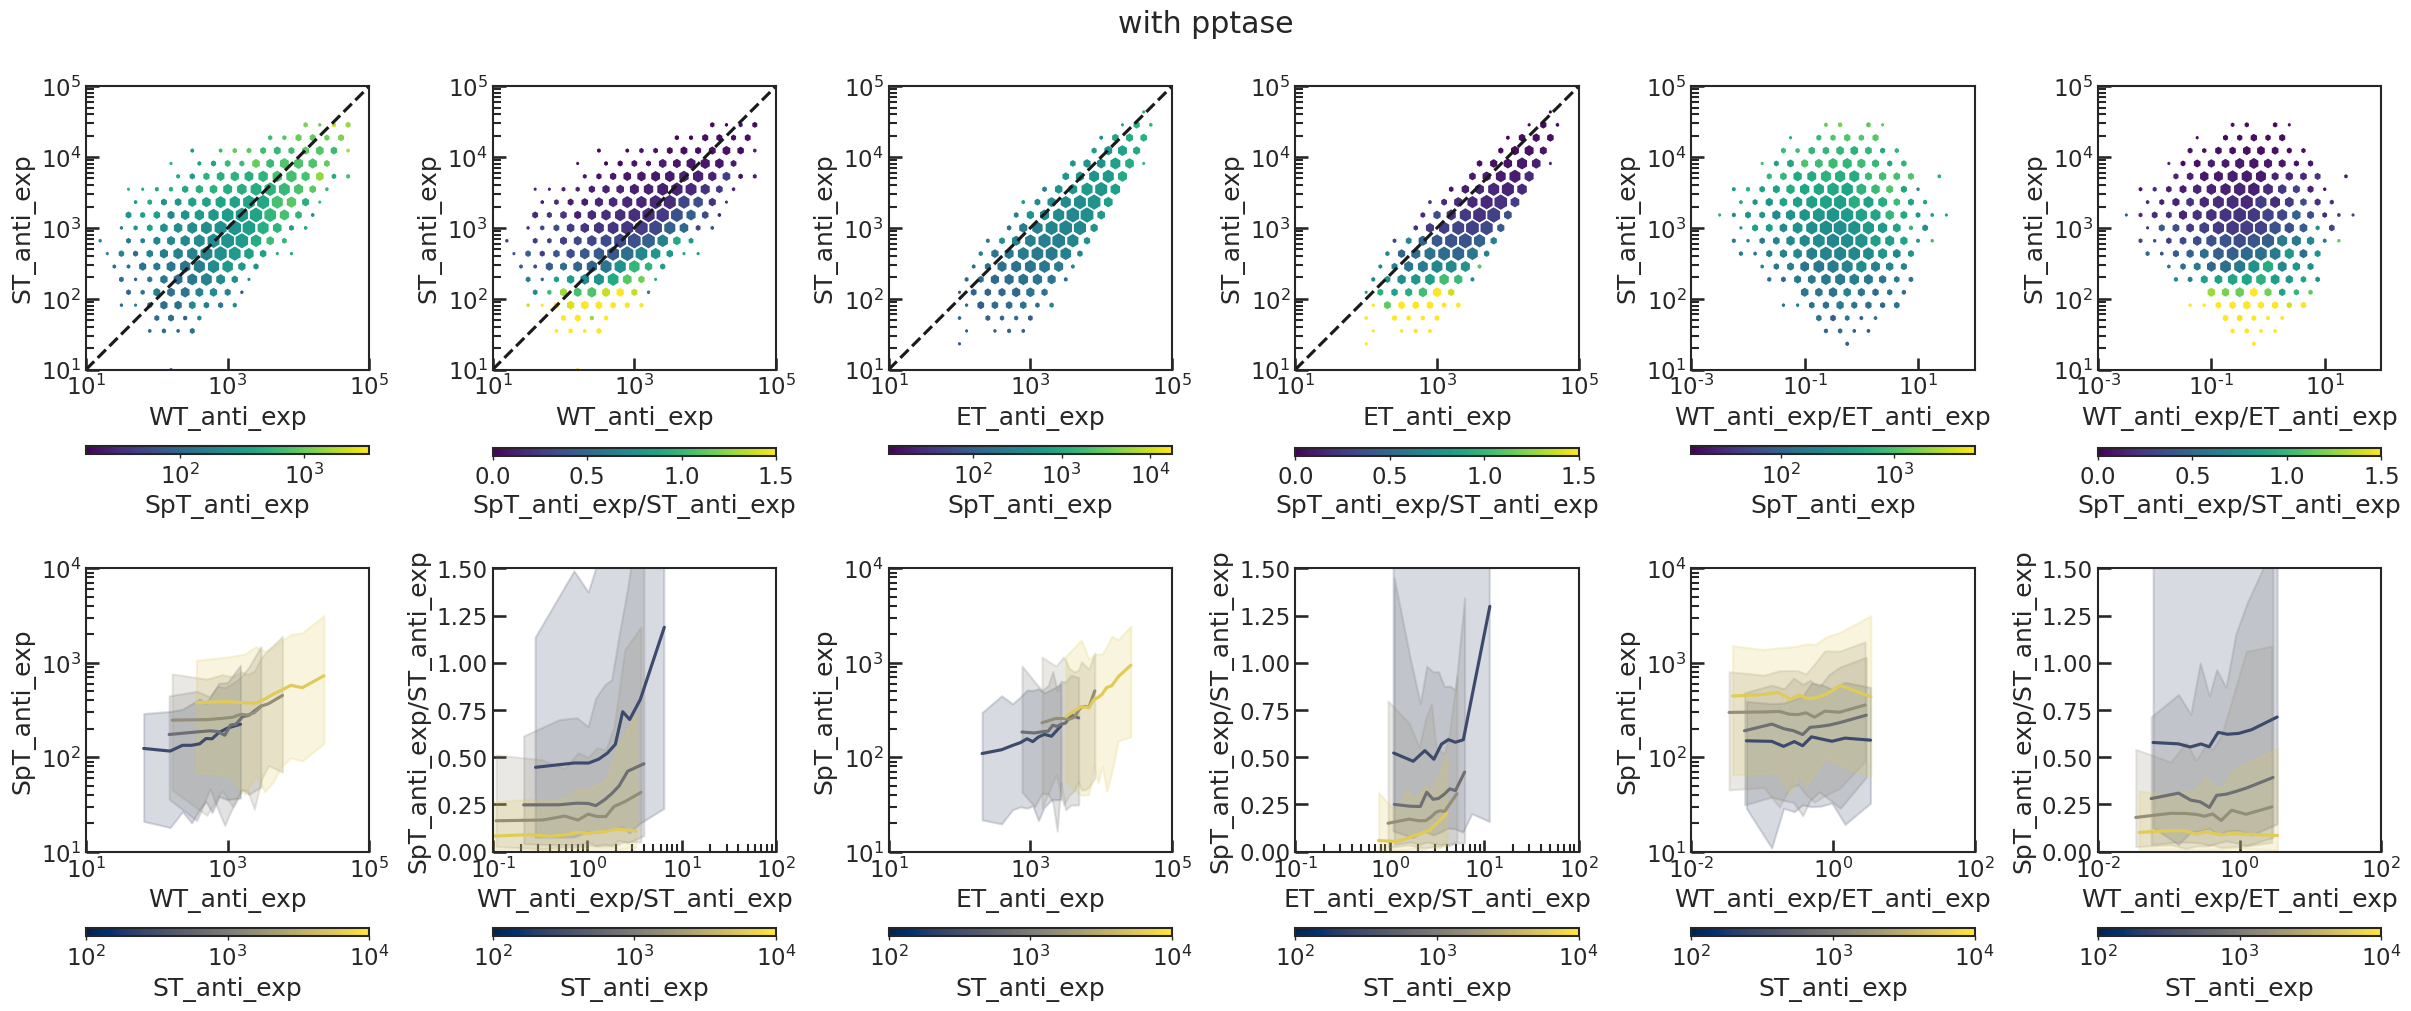

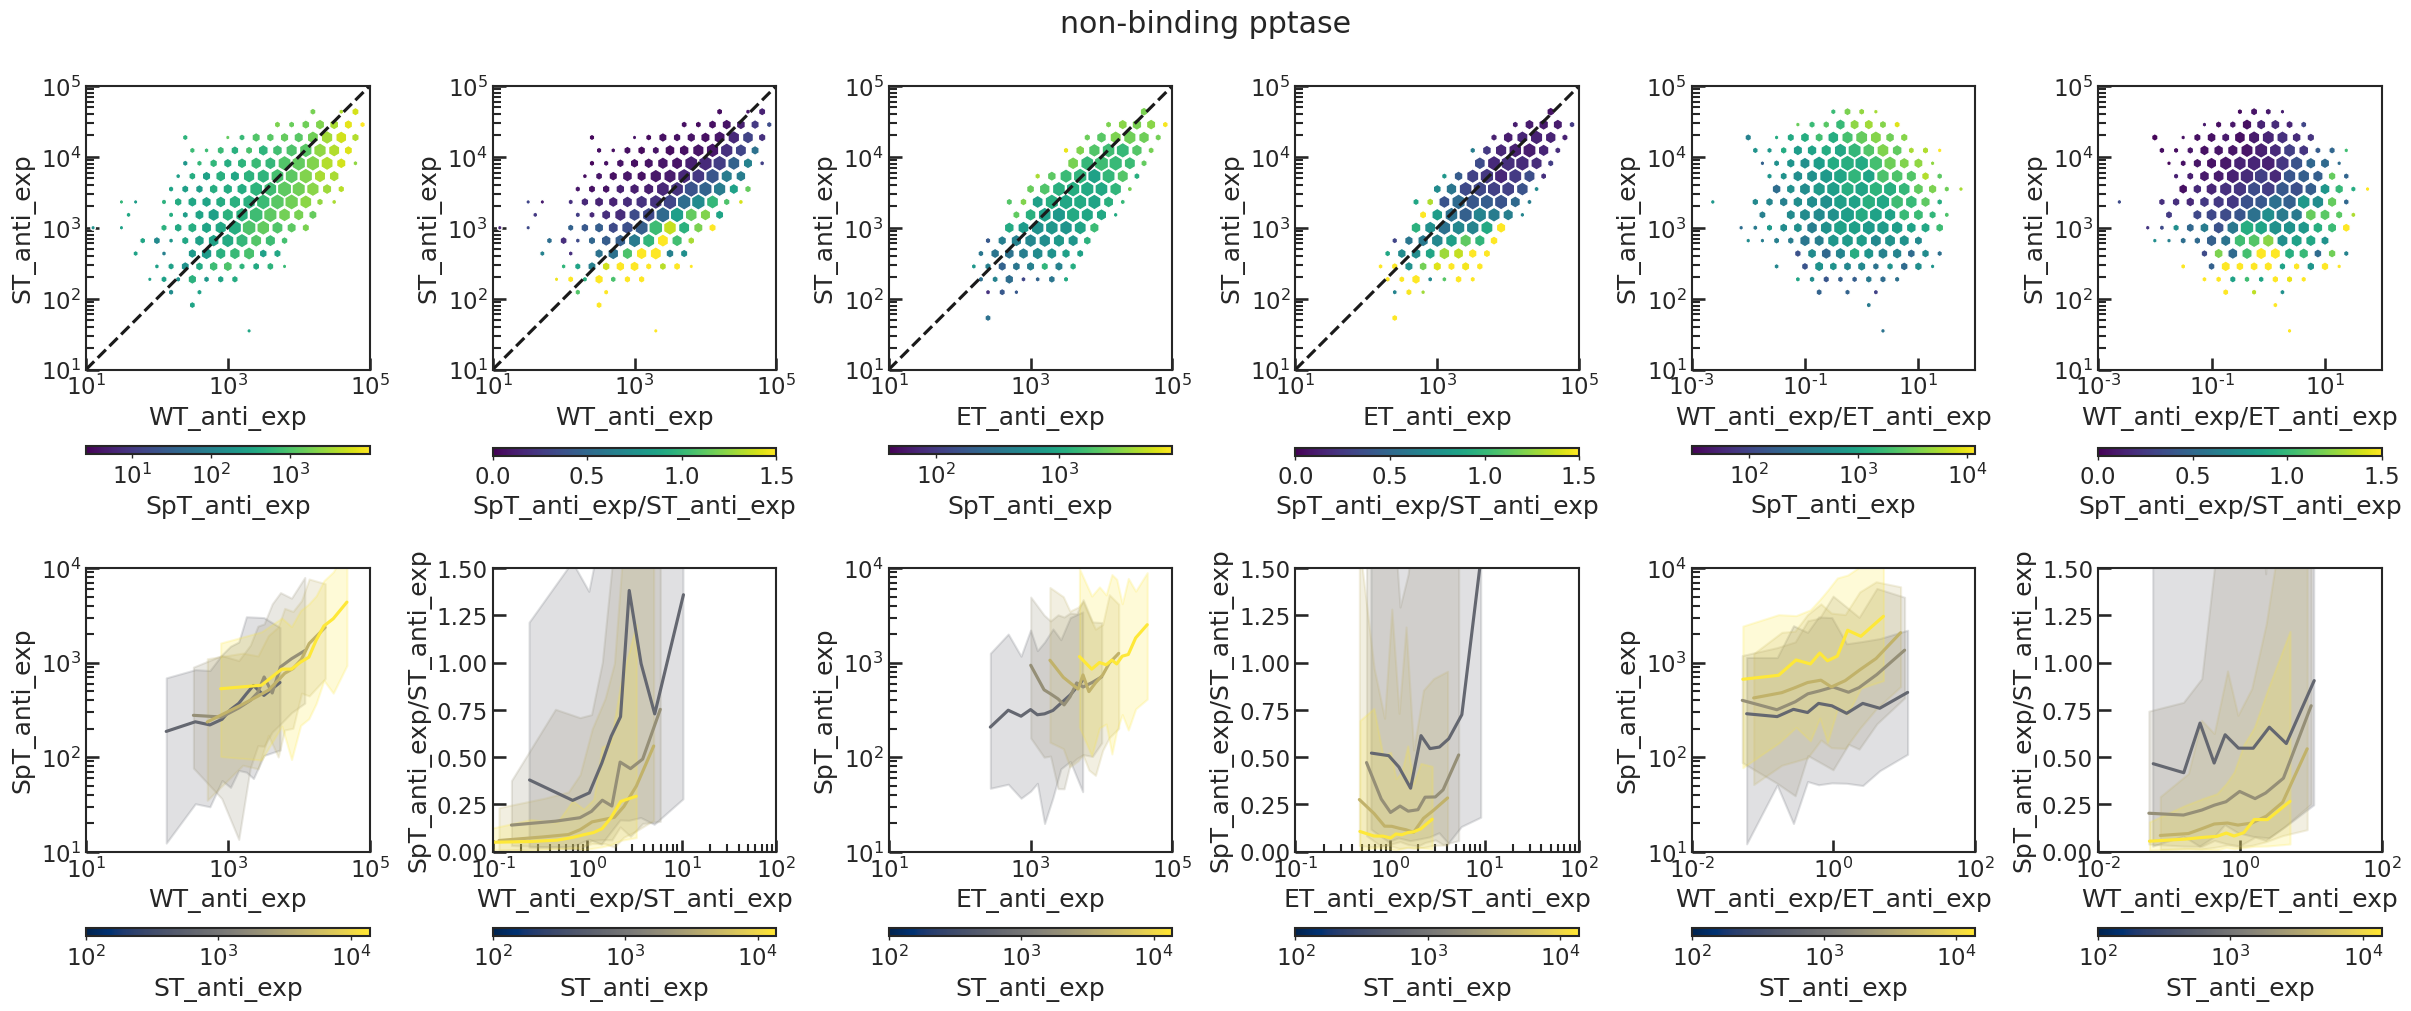

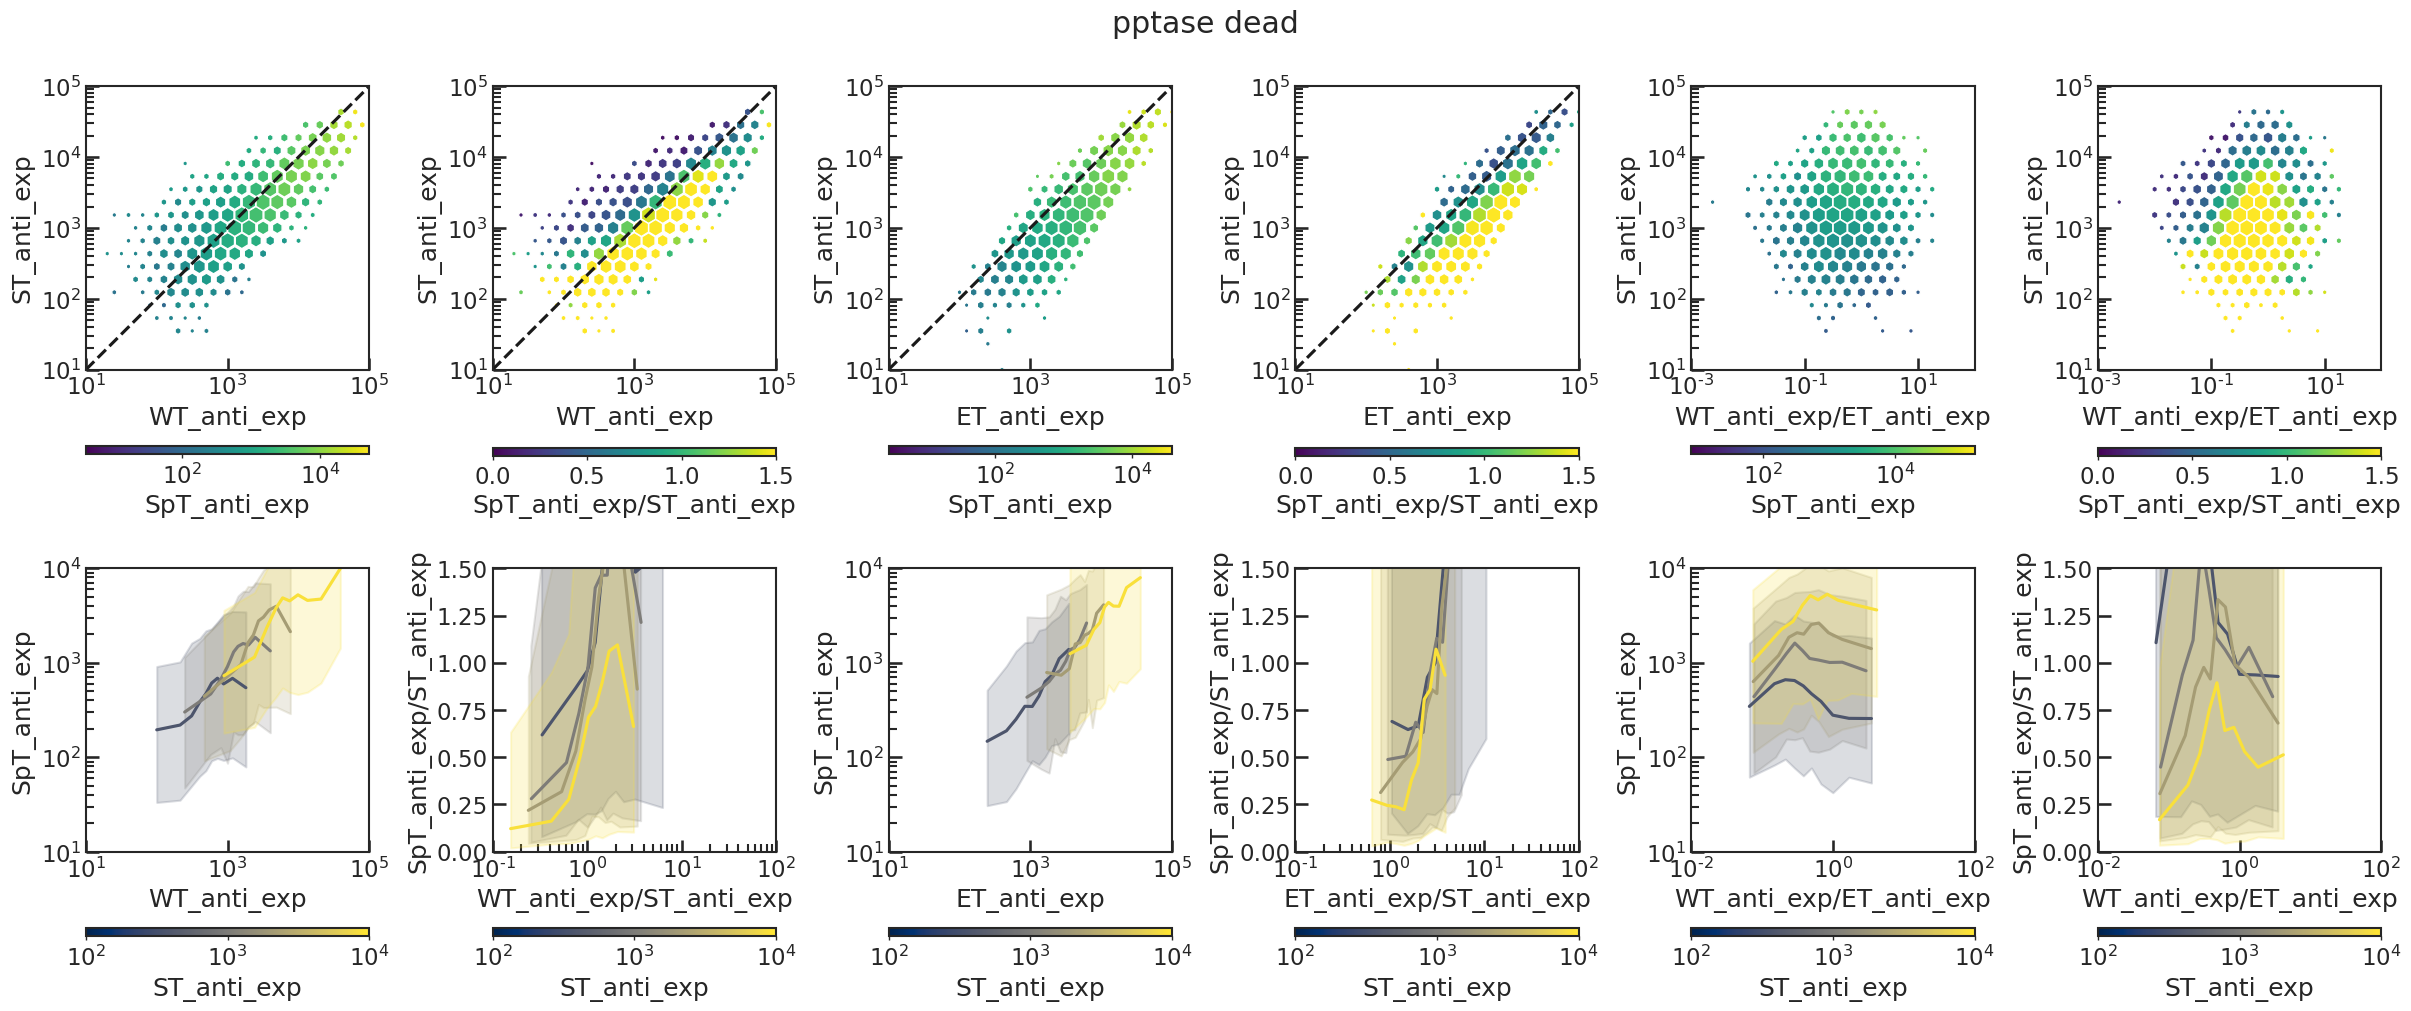

In [13]:
for index, row in df_data_info.iterrows():
    
    dataset = row['dataset']

    if row['model'] == 'push' or row['model'] == "substrate_only" or row['model'] == "non-pplatable":
        fplot.plot_push_dataset_summary(df_data, dataset)
    elif row['model'] == 'pushpull':
        fplot.plot_pushpull_dataset_summary(df_data, dataset)
                

    

Num Cells: 23564 Points per bin: 10 Num Bins: 48
Num Cells: 33619 Points per bin: 10 Num Bins: 57


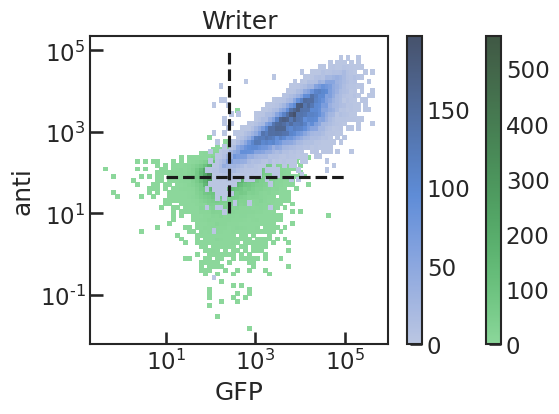

Num Cells: 26380 Points per bin: 10 Num Bins: 51
Num Cells: 33890 Points per bin: 10 Num Bins: 58


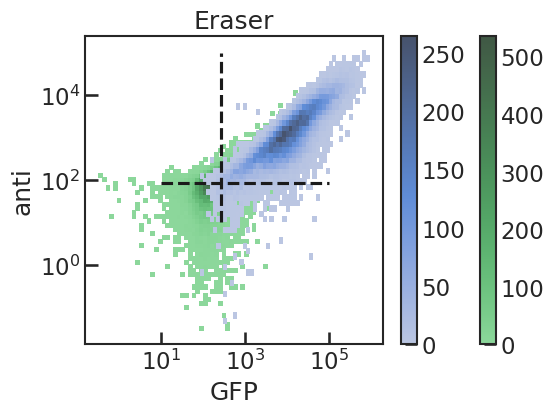

Num Cells: 27095 Points per bin: 10 Num Bins: 52
Num Cells: 20862 Points per bin: 10 Num Bins: 45


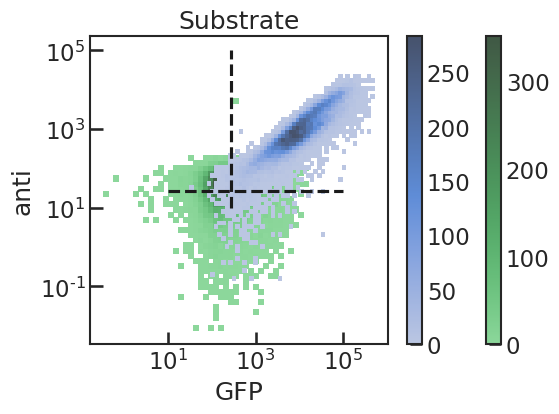

Num Cells: 27180 Points per bin: 10 Num Bins: 52
Num Cells: 30612 Points per bin: 10 Num Bins: 55


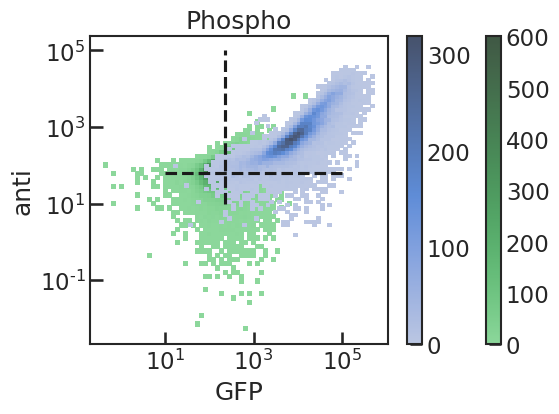

Num Cells: 27180 Points per bin: 10 Num Bins: 52
Num Cells: 57792 Points per bin: 10 Num Bins: 76


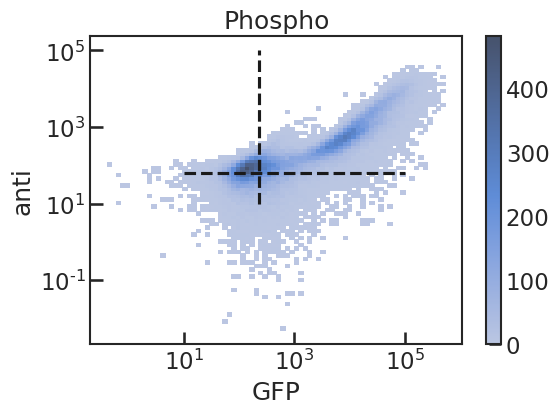

In [14]:


writer_noise = noise.Anti2GFPNoise("../data/{}/noise_writer.csv".format(label), 
                                   noise_key.loc['writer', 'anti_label'], noise_key.loc['writer', 'GFP_label'], ppbin=10, verbose=False)

empty_writer_noise = noise.Anti2GFPNoise("../data/{}/noise_empty_cell.csv".format(label), 
                                   noise_key.loc['writer', 'empty_anti_label'], noise_key.loc['writer', 'empty_GFP_label'], ppbin=10, verbose=False)


fig, ax = plt.subplots(1, 1, figsize=(6, 4))
empty_writer_noise.plot(ax, color='g')
writer_noise.plot(ax)

ax.set_title("Writer")

ax.hlines(10**np.mean(np.log10(empty_writer_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.vlines(10**np.mean(np.log10(empty_writer_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


plt.show()


eraser_noise = noise.Anti2GFPNoise("../data/{}/noise_eraser.csv".format(label), 
                                   noise_key.loc['eraser', 'anti_label'], noise_key.loc['eraser', 'GFP_label'], ppbin=10, verbose=False)

empty_eraser_noise = noise.Anti2GFPNoise("../data/{}/noise_empty_cell.csv".format(label), 
                                   noise_key.loc['eraser', 'empty_anti_label'], noise_key.loc['eraser', 'empty_GFP_label'], ppbin=10, verbose=False)


fig, ax = plt.subplots(1, 1, figsize=(6, 4))
empty_eraser_noise.plot(ax, color='g')
eraser_noise.plot(ax)

ax.set_title("Eraser")

ax.hlines(10**np.mean(np.log10(empty_eraser_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.vlines(10**np.mean(np.log10(empty_eraser_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


plt.show()

    
substrate_noise = noise.Anti2GFPNoise("../data/{}/noise_substrate_phospho_combined.csv".format(label), 
                                   noise_key.loc['substrate', 'anti_label'], noise_key.loc['substrate', 'GFP_label'], ppbin=10, verbose=False)

empty_substrate_noise = noise.Anti2GFPNoise("../data/{}/noise_empty_cell.csv".format(label), 
                                   noise_key.loc['substrate', 'empty_anti_label'], noise_key.loc['substrate', 'empty_GFP_label'], ppbin=10, verbose=False)



fig, ax = plt.subplots(1, 1, figsize=(6, 4))
empty_substrate_noise.plot(ax, color='g')
substrate_noise.plot(ax)
ax.set_title("Substrate")

ax.hlines(10**np.mean(np.log10(empty_substrate_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')
ax.vlines(10**np.mean(np.log10(empty_substrate_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')

plt.show()


    
phospho_noise = noise.Anti2GFPNoise("../data/{}/noise_substrate_phospho_combined.csv".format(label), 
                                   noise_key.loc['phospho', 'anti_label'], noise_key.loc['phospho', 'GFP_label'], ppbin=10, verbose=False)

empty_phospho_noise = noise.Anti2GFPNoise("../data/{}/noise_empty_cell.csv".format(label), 
                                   noise_key.loc['phospho', 'empty_anti_label'], noise_key.loc['phospho', 'empty_GFP_label'], ppbin=10, verbose=False)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

empty_phospho_noise.plot(ax, color='g')
phospho_noise.plot(ax)
ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(empty_phospho_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')
ax.vlines(10**np.mean(np.log10(empty_phospho_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')

plt.show()


combined_phospho_noise = noise.Anti2GFPNoise("../data/{}/noise_substrate_phospho_combined.csv".format(label), 
                                   noise_key.loc['phospho', 'anti_label'], noise_key.loc['phospho', 'GFP_label'], ppbin=10, verbose=False)
combined_phospho_noise.add_cells(empty_phospho_noise)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
combined_phospho_noise.plot(ax)

ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(empty_phospho_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.vlines(10**np.mean(np.log10(empty_phospho_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


plt.show()

In [15]:
zero = 0.0

for index, row in df_data_info.iterrows():
    
    dataset = row['dataset']
    
    df_tmp = df_data.query("dataset==@dataset")
    
    # convert antibody measurements to GFP measurements
    GFP_infer, anti_bin, GFP_bin = writer_noise.anti_to_GFP(df_data.loc[df_tmp.index, 'WT_anti_exp'])
    df_data.loc[df_tmp.index, 'WT_GFP_infer'] = GFP_infer
    df_data.loc[df_tmp.index, 'WT_conc_infer'] = np.maximum(df_data.loc[df_tmp.index, 'WT_GFP_infer'] - np.median(empty_writer_noise.get_GFP()), zero)

    GFP_infer, anti_bin, GFP_bin = substrate_noise.anti_to_GFP(df_data.loc[df_tmp.index, 'ST_anti_exp'])
    df_data.loc[df_tmp.index, 'ST_GFP_infer'] = GFP_infer
    df_data.loc[df_tmp.index, 'ST_conc_infer'] = np.maximum(df_data.loc[df_tmp.index, 'ST_GFP_infer'] - np.median(empty_substrate_noise.get_GFP()), zero)

    GFP_infer, anti_bin, GFP_bin = combined_phospho_noise.anti_to_GFP(df_data.loc[df_tmp.index, 'SpT_anti_exp'])
    df_data.loc[df_tmp.index, 'SpT_GFP_infer'] = GFP_infer
    df_data.loc[df_tmp.index, 'SpT_conc_infer'] = np.maximum(df_data.loc[df_tmp.index, 'SpT_GFP_infer'] - np.median(empty_phospho_noise.get_GFP()), zero)

    df_data.loc[df_tmp.index, 'Sp_frac_GFP_infer'] = df_data.loc[df_tmp.index, 'SpT_GFP_infer'] / df_data.loc[df_tmp.index, 'ST_GFP_infer']
    df_data.loc[df_tmp.index, 'Sp_frac_conc_infer'] = df_data.loc[df_tmp.index, 'SpT_conc_infer'] / df_data.loc[df_tmp.index, 'ST_conc_infer']
      
    if row['model'] == 'pushpull':
        GFP_infer, anti_bin, GFP_bin = writer_noise.anti_to_GFP(df_data.loc[df_tmp.index, 'ET_anti_exp'])
        df_data.loc[df_tmp.index, 'ET_GFP_infer'] = GFP_infer
        df_data.loc[df_tmp.index, 'ET_conc_infer'] = np.maximum(df_data.loc[df_tmp.index, 'ET_GFP_infer'] - np.median(empty_writer_noise.get_GFP()), zero)
    else:
        df_data.loc[df_tmp.index, 'ET_GFP_infer'] = 0.0
        df_data.loc[df_tmp.index, 'ET_conc_infer'] = 0.0
    
    
display(df_data)
print(len(df_data))
print(len(df_data.dropna()))

ST_anti_exp  SpT_anti_exp  WT_anti_exp  ET_anti_exp  \
dataset                                                                  
127         0       596.003052    127.600983   139.194336     0.000000   
            1       642.792908     47.050320    63.249672     0.000000   
            2       504.310577     60.162514    80.487480     0.000000   
            3       975.909546    207.053024   150.405548     0.000000   
            4       504.870697     50.226593   122.371445     0.000000   
...                        ...           ...          ...          ...   
pptase dead 20012   728.979065   1658.475220  1414.776611  3427.544922   
            20013   861.156677   3132.601562  1403.224487  4458.793457   
            20014   857.985962    102.973625  1212.635132  1800.807251   
            20015   473.853760   1973.187866  1084.941284  1246.285767   
            20016  2178.468994   6118.945312  2886.015625  8448.372070   

                   Sp_frac_anti_exp  WT_GFP_infer  WT_conc_infer  \
dataset                                                            
127         0              0.214095    532.302307     305.926071   
            1              0.073197    334.265106     107.888870   
            2              0.119297    221.987122       0.000000   
            3              0.212164    809.793824     583.417588   
            4              0.099484    184.230644       0.000000   
...                             ...           ...            ...   
pptase dead 20012          2.275066   3468.385620    3242.009384   
            20013          3.637667   1183.406494     957.030258   
            20014          0.120018   3215.857544    2989.481308   
            20015          4.164128   2292.457398    2066.081162   
            20016          2.808828   6589.751221    6363.374985   

                   ST_GFP_infer  ST_conc_infer  SpT_GFP_infer  SpT_conc_infer  \
dataset                                                                         
127         0       6229.964111    5995.590340     162.856857        0.000000   
            1       8458.594238    8224.220467     230.449577       27.562355   
            2      12964.131350   12729.757578     354.028809      151.141586   
            3       9460.180664    9225.806892    3851.792480     3648.905258   
            4      10987.011230   10752.637458    1887.300903     1684.413681   
...                         ...            ...            ...             ...   
pptase dead 20012   5886.027344    5651.653573   18758.136720    18555.249497   
            20013   9624.711426    9390.337654   49804.058595    49601.171372   
            20014  15596.412595   15362.038824     832.497009      629.609787   
            20015   2871.090942    2636.717171   25609.506835    25406.619612   
            20016   9029.091797    8794.718025   64998.683590    64795.796367   

                   Sp_frac_GFP_infer  Sp_frac_conc_infer  ET_GFP_infer  \
dataset                                                                  
127         0               0.026141            0.000000      0.000000   
            1               0.027244            0.003351      0.000000   
            2               0.027308            0.011873      0.000000   
            3               0.407158            0.395511      0.000000   
            4               0.171776            0.156651      0.000000   
...                              ...                 ...           ...   
pptase dead 20012           3.186893            3.283154   2573.102051   
            20013           5.174603            5.282150  12216.990720   
            20014           0.053377            0.040985   1546.833862   
            20015           8.919783            9.635702   3679.690796   
            20016           7.198806            7.367581  31022.351560   

                   ET_conc_infer  
dataset                           
127         0           0.000000  
            1           0.000000  
            2 

132262
131082


In [16]:
# the problem might simply be nans

start = time.time()

res, param_dict = fit.fit_push(df_data_info, df_data, empty_phospho_noise)

end = time.time()

print(end-start)

{'bg_phospho_rate': 0, '375': 1, 'L+A': 2, '419': 3, 'kinase_dead': 4, 'kinase_wt': 5, 'E+A': 6, 'E+E': 7, 'kinase_non-binding': 8, 'pptase_wt': 9, 'pptase_non-binding': 10, 'pptase_dead': 11}
{'127': [0], '174': [], '375': [0, 1, 2], '419': [0, 3, 2], '421': [0, 4, 2], 'E+A': [0, 5, 6], 'E+E': [0, 5, 7], 'L+A': [0, 5, 2], 'RR+A': [0, 5, 8], 'with pptase': [0, 5, 2, 9, 2], 'non-binding pptase': [0, 5, 2, 9, 10], 'pptase dead': [0, 5, 2, 11, 2]}
[-2.0, -1.0, 3.0, -1.0, -1.0, -1.0, 3.0, 3.0, 3.0, -1.0, 3.0, -1.0]
[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
Total Loss: 10.117882861802645 Regularization: 0.0
bg_phospho_rate -2.0 -2.0
375 -1.0 -1.0
L+A 3.0 3.0
419 -1.0 -1.0
kinase_dead -1.0 -1.0
kinase_wt -1.0 -1.0
E+A 3.0 3.0
E+E 3.0 3.0
kinase_non-binding 3.0 3.0
pptase_wt -1.0 -1.0
pptase_non-binding 3.0 3.0
pptase_dead -1.0 -1.0
Total Time Elapsed 2.74114513397216

,dataset,model,kinase_variant,kinase_zipper,pptase_variant,pptase_zipper,substrate_col,phospho_col,writer_col,eraser_col,bg_phospho_rate,kinase_phospho_rate,kinase_binding_affinity,pptase_dephospho_rate,pptase_binding_affinity
0,127,substrate_only,NaN,NaN,NaN,NaN,ST,SpT,WT,NaN,0.00707,NaN,NaN,NaN,NaN
1,174,non-pplatable,174,L+A,NaN,NaN,ST,SpT,WT,NaN,NaN,NaN,NaN,NaN,NaN
2,375,push,375,L+A,NaN,NaN,ST,SpT,WT,NaN,0.00707,2.586417e-02,1.413696e-01,NaN,NaN
3,419,push,419,L+A,NaN,NaN,ST,SpT,WT,NaN,0.00707,2.678302e-01,1.413696e-01,NaN,NaN
4,421,push,kinase_dead,L+A,NaN,NaN,ST,SpT,WT,NaN,0.00707,7.149122e-07,1.413696e-01,NaN,NaN
5,E+A,push,kinase_wt,E+A,NaN,NaN,ST,SpT,WT,NaN,0.00707,5.746246e+00,3.360813e+04,NaN,NaN
6,E+E,push,kinase_wt,E+E,NaN,NaN,ST,SpT,WT,NaN,0.00707,5.746246e+00,9.659389e+05,NaN,NaN
7,L+A,push,kinase_wt,L+A,NaN,NaN,ST,SpT,WT,NaN,0.00707,5.746246e+00,1.413696e-01,NaN,NaN
8,RR+A,push,kinase_wt,kinase_non-binding,NaN,NaN,ST,SpT,WT,NaN,0.00707,5.746246e+00,3.264046e+06,NaN,NaN
9,with pptase,pushpull,kinase_wt,L+A,pptase_wt,L+A,ST,SpT,WT,pptase,0.00707,5.746246e+00,1.413696e-01,10.793260,0.141370


2973.5007662773132


In [17]:
display(df_data_info)

,dataset,model,kinase_variant,kinase_zipper,pptase_variant,pptase_zipper,substrate_col,phospho_col,writer_col,eraser_col,bg_phospho_rate,kinase_phospho_rate,kinase_binding_affinity,pptase_dephospho_rate,pptase_binding_affinity
0,127,substrate_only,NaN,NaN,NaN,NaN,ST,SpT,WT,NaN,0.00707,NaN,NaN,NaN,NaN
1,174,non-pplatable,174,L+A,NaN,NaN,ST,SpT,WT,NaN,NaN,NaN,NaN,NaN,NaN
2,375,push,375,L+A,NaN,NaN,ST,SpT,WT,NaN,0.00707,2.586417e-02,1.413696e-01,NaN,NaN
3,419,push,419,L+A,NaN,NaN,ST,SpT,WT,NaN,0.00707,2.678302e-01,1.413696e-01,NaN,NaN
4,421,push,kinase_dead,L+A,NaN,NaN,ST,SpT,WT,NaN,0.00707,7.149122e-07,1.413696e-01,NaN,NaN
5,E+A,push,kinase_wt,E+A,NaN,NaN,ST,SpT,WT,NaN,0.00707,5.746246e+00,3.360813e+04,NaN,NaN
6,E+E,push,kinase_wt,E+E,NaN,NaN,ST,SpT,WT,NaN,0.00707,5.746246e+00,9.659389e+05,NaN,NaN
7,L+A,push,kinase_wt,L+A,NaN,NaN,ST,SpT,WT,NaN,0.00707,5.746246e+00,1.413696e-01,NaN,NaN
8,RR+A,push,kinase_wt,kinase_non-binding,NaN,NaN,ST,SpT,WT,NaN,0.00707,5.746246e+00,3.264046e+06,NaN,NaN
9,with pptase,pushpull,kinase_wt,L+A,pptase_wt,L+A,ST,SpT,WT,pptase,0.00707,5.746246e+00,1.413696e-01,10.793260,0.141370


In [18]:
# save model parameters (don't forget to do this)

df_data_info.to_csv("../data/"+label+"/model_params.csv", sep=',', index=False)
